In [38]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
#h parameters
N = 5000
n_update = 100
K = 4
batch_size = 32
gamma = 0.99
learning_rate = 0.001

num_action = 0

seed = 0
epsilon = 1
min_epsilon = 0.1
np.random.seed(seed)
torch.manual_seed(seed)


In [9]:
actions = [ -2 + 0.4*i for i in range(11)]

print(actions)


[-2.0, -1.6, -1.2, -0.7999999999999998, -0.3999999999999999, 0.0, 0.40000000000000036, 0.8000000000000003, 1.2000000000000002, 1.6, 2.0]


In [10]:
class Qnet(nn.Module):
    def __init__(self, input_feature, num_action):
        super(Qnet,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 32)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 32, out_features = 256)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features = 256, out_features = 128)
        self.activation3 = nn.ReLU()
        self.linear4 = nn.Linear(in_features = 128, out_features = num_action)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.linear4(x)
        return x

In [11]:

def get_action(state,epsilon):
    if(random.random() < epsilon):
        action = random.choice(actions)
    else:
        idx = np.argmax(learning_net(torch.Tensor(state)).detach().numpy(),0)
        action = actions[idx]
    return action


def cal_target_val(batch):
    reward = [episode[2] for episode in batch]
    next_state = [episode[3] for episode in batch]
    done = [episode[4] for episode in batch]
    temp_value =  gamma*np.amax(target_net(torch.Tensor(next_state)).detach().numpy() , axis = 1)
    target_value=[]
    for i in range(batch_size):
        if(done[i]):
            target_value.append(reward[i])
        else:
            target_value.append(reward[i]+temp_value[i])
    return target_value

In [12]:
#training
num_train = 5
reward_plot = []
for i in range(num_train):
    reward_plot.append([])
    
for n in range(num_train):
    print("training... {}/{}".format(n,num_train))
    seed = n
    epsilon = 1
    min_epsilon = 0.1
    np.random.seed(seed)
    torch.manual_seed(seed)

    learning_net = Qnet(3,11)
    target_net = Qnet(3,11)
    optimizer = optim.Adam(learning_net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    num_episode = 0
    buffer_index = 0
    step = 0
    replay_buffer = []
    state = []
    env = gym.make('Pendulum-v0')
    for iteration in range(300):
        done = False
        observation = env.reset()
        state = observation
        learning_net.zero_grad()
        reward_plot[n].append(0)

        for t in range(10000):
            if(step%n_update==0):
                target_net.load_state_dict(learning_net.state_dict())
                epsilon = epsilon * 0.99
                if (epsilon < min_epsilon):
                    epsilon = min_epsilon
            #env.render()
            action = get_action(state, epsilon)
            obs , reward, done, info = env.step([action])
            reward_plot[n][-1] = reward_plot[n][-1] + reward
            next_state = obs
            episode = (state, action, reward, next_state , done)
            if(num_episode < N):
                replay_buffer.append(episode)
                num_episode = num_episode + 1
            else:
                replay_buffer[buffer_index] = episode
            buffer_index = (buffer_index + 1) % N 
            if done:
                step = step+1
                break
            if(step%K == 0 and step>=batch_size):

                batch = random.sample(replay_buffer,batch_size)
                target_value = cal_target_val(batch)

                action_batch = [e[1] for e in batch]
                action_idx = [actions.index(action_batch[i]) for i in range(batch_size)]
                action_idx = tuple(action_idx)

                temp_state = [e[0] for e in batch]
                output = learning_net(torch.Tensor(temp_state))
                output =  [ output[i][action_idx[i]] for i in range(batch_size)]
                output = torch.stack(output)

                loss = criterion(torch.Tensor(target_value), output)
                loss.backward()

                optimizer.step()
                learning_net.zero_grad()

            state = next_state[:]
            step = step+1
    torch.save(learning_net.state_dict() , './DQN_model/model_seed_{}.pth'.format(n))
print('finish')

training... 0/5
training... 1/5
training... 2/5
training... 3/5
training... 4/5
finish


In [66]:
#test
state = []
env = gym.make('Pendulum-v0')
done = False
reward_sum=0
observation = env.reset()
state = observation

for t in range(10000):
    env.render()
    action = get_action(state, 0.1)
    obs , reward, done, info = env.step([action])
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

reward -495.4666076612133


In [19]:
print( reward_plot[0][0])
print( reward_plot[1][0])
print( reward_plot[2][0])
print( reward_plot[3][0])
print( reward_plot[4][0])


-1347.6994147000191
-1340.6185721289985
-1262.1743276120824
-1461.8593992349165
-1055.272034234369


In [20]:
reward_np = np.array(reward_plot)

In [21]:
reward_np

array([[-1347.6994147 , -1734.7036583 , -1252.12242299, ...,
         -128.30011887,  -250.71976999,  -250.18065701],
       [-1340.61857213,  -865.29077117, -1436.9250741 , ...,
         -232.64054556,  -352.18725862,  -119.44863558],
       [-1262.17432761,  -893.48882502,  -949.29412232, ...,
         -345.42786137,  -128.86673013,  -482.28784999],
       [-1461.85939923,  -860.4316499 , -1624.71908268, ...,
           -1.86380739,  -119.62312293,  -128.28968726],
       [-1055.27203423, -1196.56435672, -1730.6057926 , ...,
         -127.55354211,  -126.30827714,  -117.71950964]])

In [31]:
reward_mean = np.mean(reward_np,axis = 0)
reward_std = np.std(reward_np,axis=0)

Text(0.5, 1.0, 'reward')

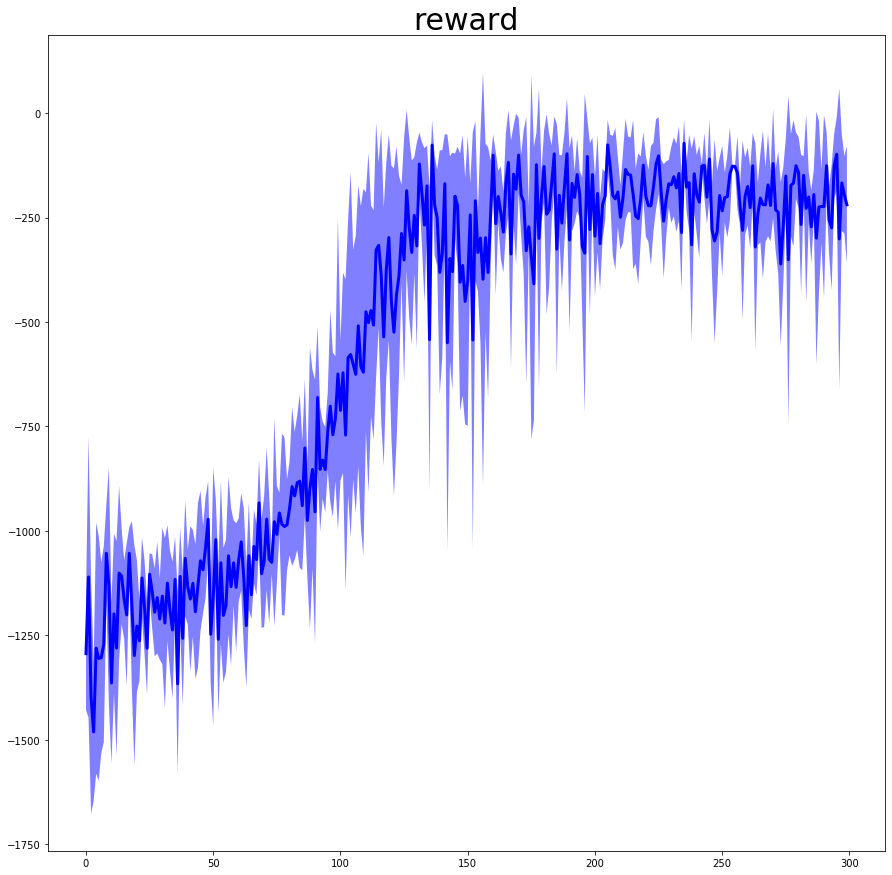

In [55]:
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_mean))),reward_mean, lw = 3, label = 'reward', color = 'blue')
axe.fill_between(list(range(len(reward_mean))),reward_mean+reward_std, reward_mean-reward_std , facecolor = 'blue' , alpha = 0.5)
axe.set_title('reward', fontsize = 30)


In [60]:
reward_smoothed_mean = []
reward_smoothed_std = []
for i in range(len(reward_mean)):
    reward_smoothed_mean.append(0)
    reward_smoothed_std.append(0)
    for j in range(min(i+1,10)):
        reward_smoothed_mean[-1] = reward_smoothed_mean[-1] + reward_mean[i-j]
        reward_smoothed_std[-1] = reward_smoothed_std[-1] + reward_std[i-j]
    reward_smoothed_mean[-1] = reward_smoothed_mean[-1] / min(10,i+1)
    reward_smoothed_std[-1] = reward_smoothed_std[-1] / min(10,i+1)
reward_smoothed_mean = np.array(reward_smoothed_mean)   
reward_smoothed_std = np.array(reward_smoothed_std)   

Text(0.5, 1.0, 'reward')

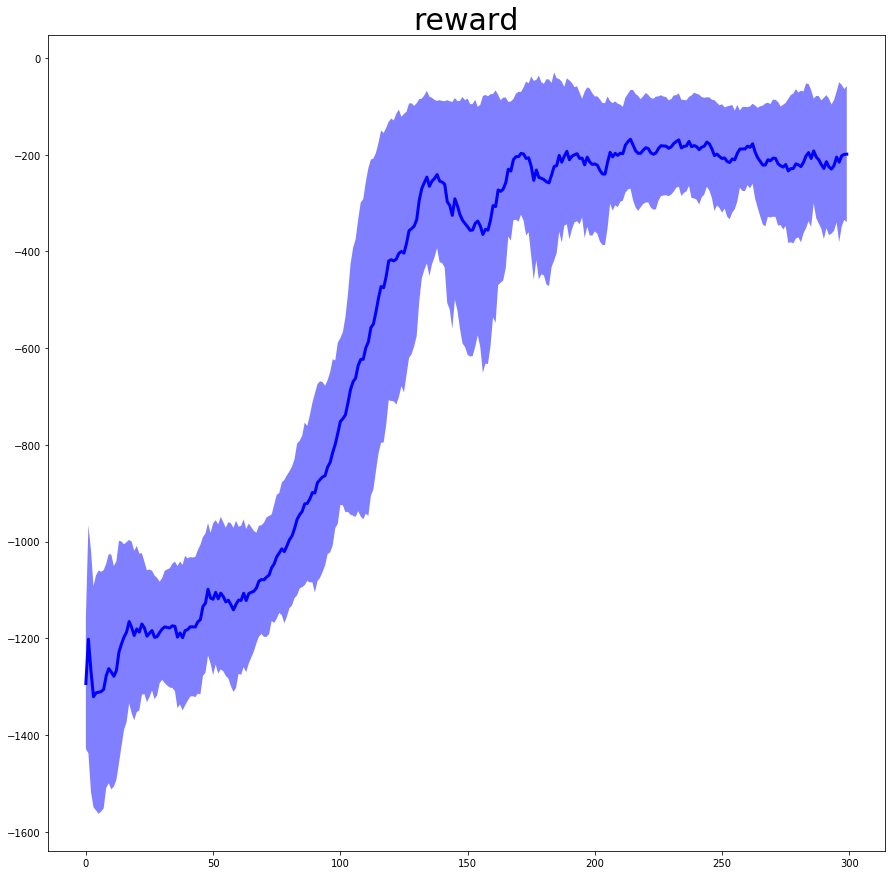

In [61]:
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_smoothed_mean))),reward_smoothed_mean, lw = 3, label = 'reward', color = 'blue')
axe.fill_between(list(range(len(reward_smoothed_mean))) ,reward_smoothed_mean + reward_smoothed_std, reward_smoothed_mean - reward_smoothed_std , facecolor = 'blue' , alpha = 0.5)
axe.set_title('reward', fontsize = 30)
